In [3]:
%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import timm
from PIL import Image
import albumentations as A

import cv2
import os
from pytorch_models_imp.datasets.penn_funn import PennFudanDataset, center_to_corners_format
from torch.utils.data import DataLoader
from pytorch_models_imp.detr import DETR, PositionEncoder, HungarianMatcher, DetrLoss

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
sizes = (224, 224)
transforms = A.Compose([
#     A.RandomCrop(width=450, height=450),
    A.Resize(sizes[0], sizes[1]),
    A.HorizontalFlip(p=0.5),
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['class_labels']))

In [5]:
root = 'data/PennFudanPed'
imgs = list(sorted(os.listdir(os.path.join(root, "PNGImages"))))[:40]
masks = list(sorted(os.listdir(os.path.join(root, "PedMasks"))))[:40]

In [6]:
dataset = PennFudanDataset('data/PennFudanPed', imgs, masks, transforms)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


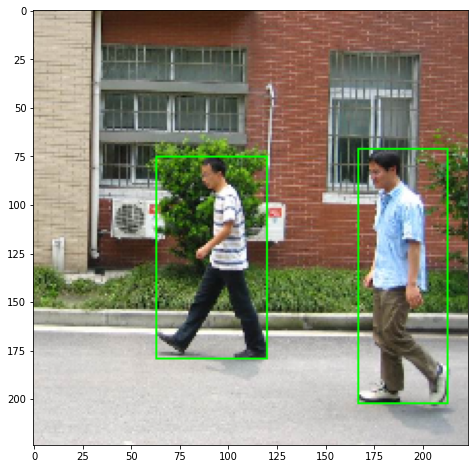

In [7]:
im, target = dataset[0]
plt.figure(figsize=(8, 8))
display = im.numpy().transpose(1, 2, 0).copy()
h, w, c = display.shape

for bbox in target['bboxes']:
    bbox = center_to_corners_format(bbox) * np.array([w, h, w, h])
    bbox = list(map(int, bbox))
    cv2.rectangle(display, (bbox[0], bbox[1]), (bbox[2], bbox[3]), color=(0, 255, 0))
plt.imshow(display)

In [8]:
BATCH_SIZE = 4
train_loader = DataLoader(dataset, batch_size=BATCH_SIZE, collate_fn=dataset.collate_fn)

In [9]:
imgs, targets = next(iter(train_loader))

### Position encoding

In [10]:
HIDDEN_DIM = 256

pos_encoder = PositionEncoder(max_hw=70, hidden_dim=HIDDEN_DIM)

In [11]:
h, w = sizes[0] // 16, sizes[1] // 32
pos_example = torch.randn(BATCH_SIZE, HIDDEN_DIM, h, w)
pos_out = pos_encoder(pos_example)

In [12]:
assert pos_out.shape == (1, HIDDEN_DIM, h, w)

### Minimal detr

In [13]:
num_classes = 2
num_queries = 10
n_head = 4
num_encoder_layers = 3
num_decoder_layers = 3
dropout = 0.0
detr = DETR(num_classes, num_queries, HIDDEN_DIM, n_head, num_encoder_layers, num_decoder_layers, dropout)

In [14]:
preds = detr(imgs)

In [15]:
preds['logits'].shape

torch.Size([4, 10, 3])

In [16]:
preds['bboxes'].shape

torch.Size([4, 10, 4])

### Match prediction via hungarian matches

In [17]:
matcher = HungarianMatcher()
matched_indexes = matcher(preds, targets)

In [18]:
matched_indexes

[(tensor([5, 6]), tensor([1, 0])),
 (tensor([2]), tensor([0])),
 (tensor([5]), tensor([0])),
 (tensor([5, 6]), tensor([1, 0]))]

### Hungarian based loss

In [19]:
losses_types = ["labels", "boxes"]
detr_loss = DetrLoss(matcher, num_classes, 1, losses_types)
losses = detr_loss(preds, targets)

In [20]:
indices = detr_loss._get_src_permutation_idx(matched_indexes)

In [23]:
target_classes_o = torch.cat([t["labels"][J] for t, (_, J) in zip(targets, matched_indexes)])

In [26]:
target_classes_o

tensor([1, 1, 1, 1, 1, 1])

In [28]:
src_logits = preds['logits']

In [29]:
src_logits.shape

torch.Size([4, 10, 3])

In [30]:
target_classes = torch.full(
    src_logits.shape[:2], num_classes, dtype=torch.int64, device=src_logits.device
)

In [33]:
target_classes[indices] = target_classes_o

In [35]:
target_classes

tensor([[2, 2, 2, 2, 2, 1, 1, 2, 2, 2],
        [2, 2, 1, 2, 2, 2, 2, 2, 2, 2],
        [2, 2, 2, 2, 2, 1, 2, 2, 2, 2],
        [2, 2, 2, 2, 2, 1, 1, 2, 2, 2]])

In [36]:
targets

[{'bboxes': tensor([[0.4114, 0.5700, 0.2540, 0.4646],
          [0.8524, 0.6110, 0.2057, 0.5877]]),
  'labels': tensor([1, 1])},
 {'bboxes': tensor([[0.2824, 0.5688, 0.2703, 0.6932]]), 'labels': tensor([1])},
 {'bboxes': tensor([[0.2296, 0.6225, 0.3215, 0.6427]]), 'labels': tensor([1])},
 {'bboxes': tensor([[0.3813, 0.4987, 0.3939, 0.7003],
          [0.9306, 0.3010, 0.0985, 0.2997]]),
  'labels': tensor([1, 1])}]

In [37]:
matched_indexes

[(tensor([5, 6]), tensor([1, 0])),
 (tensor([2]), tensor([0])),
 (tensor([5]), tensor([0])),
 (tensor([5, 6]), tensor([1, 0]))]

In [ ]:
loss_ce = nn.functional.cross_entropy(src_logits.transpose(1, 2), target_classes, self.empty_weight)

In [39]:
src_logits.transpose(1, 2).shape

torch.Size([4, 3, 10])

In [40]:
target_classes.shape

torch.Size([4, 10])

In [41]:
target_classes

tensor([[2, 2, 2, 2, 2, 1, 1, 2, 2, 2],
        [2, 2, 1, 2, 2, 2, 2, 2, 2, 2],
        [2, 2, 2, 2, 2, 1, 2, 2, 2, 2],
        [2, 2, 2, 2, 2, 1, 1, 2, 2, 2]])

In [ ]:
losses

In [ ]:
full_loss = sum(losses.values())

### Load model

In [216]:
checkpoint = "model_outputs/detection_transforer/transformer_model"
model = torch.load(checkpoint)
model.eval();

In [217]:
output = model(imgs)
logits = output['logits']
bboxes = output['bboxes']

In [218]:
bboxes.shape

torch.Size([4, 10, 4])

In [219]:
import torchmetrics
from torchmetrics.detection import MAP

In [220]:
probas = output['logits'].softmax(-1)[:, :, :-1]

In [221]:
keep_values, keep_indexes = probas.max(-1)
keep_indexes

tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [222]:
mask = keep_values > 0.001

In [223]:
mask.shape

torch.Size([4, 10])

In [295]:
imgs, targets = next(iter(train_loader))


preds = []
for i in range(len(imgs)):
    b, h, w, c = imgs.shape
    
    
    obj_prob = probas[i]
    obj_bboxes = bboxes[i]
    keep_values = obj_prob.max(-1).values > 0.002
    obj_prob_keep = obj_prob[keep_values]
    
    obj_bboxes = center_to_corners_format(obj_bboxes[keep_values]) * torch.as_tensor([w, h, w, h])
    
    pred_dict = {"boxes": obj_bboxes.detach(), "scores": obj_prob_keep.detach().flatten(), "labels": torch.as_tensor([1] * len(obj_prob_keep))}
    preds.append(pred_dict)

In [296]:
for objs in targets:
    objs["boxes"] = objs.pop("bboxes")
    objs['boxes'] = center_to_corners_format(objs['boxes']) * torch.as_tensor([w, h, w, h])
#     objs['labels'] = torch.as_tensor([0] * len(objs['labels']))

In [297]:
# preds = [
#     dict(
#         # The boxes keyword should contain an [N,4] tensor,
#         # where N is the number of detected boxes with boxes of the format
#         # [xmin, ymin, xmax, ymax] in absolute image coordinates
#         boxes=torch.Tensor([[258.0, 41.0, 606.0, 285.0]]),
#         # The scores keyword should contain an [N,] tensor where
#         # each element is confidence score between 0 and 1
#         scores=torch.Tensor([0.536]),
#         # The labels keyword should contain an [N,] tensor
#         # with integers of the predicted classes
#         labels=torch.IntTensor([0]),
#     )
# ]

# # Target should be a list of elements, where each element is a dict
# # containing 2 keys: boxes and labels. Each keyword should be formatted
# # similar to the preds argument. The number of elements in preds and
# # target need to match
# target = [
#     dict(
#         boxes=torch.Tensor([[214.0, 41.0, 562.0, 285.0]]),
#         labels=torch.IntTensor([0]),
#     )
# ]

In [298]:
preds[0]['scores'].flatten().shape

torch.Size([4])

In [299]:
targets[:1]

[{'labels': tensor([1, 1]),
  'boxes': tensor([[ 63.7138,   1.0131, 120.6154,   2.4067],
          [167.8998,   0.9515, 213.9821,   2.7146]])}]

In [300]:
metric = MAP()
metric.update(preds[:1], targets[:1])

In [301]:
metric.compute()

{'map': tensor(0.1515),
 'map_50': tensor(0.5050),
 'map_75': tensor(0.),
 'map_small': tensor(0.1515),
 'map_medium': tensor([-1.]),
 'map_large': tensor([-1.]),
 'mar_1': tensor(0.1500),
 'mar_10': tensor(0.1500),
 'mar_100': tensor(0.1500),
 'mar_small': tensor(0.1500),
 'mar_medium': tensor([-1.]),
 'mar_large': tensor([-1.]),
 'map_per_class': tensor([-1.]),
 'mar_100_per_class': tensor([-1.])}